### <center> Elektrotehnički fakultet </center>
### <center> Univerzitet u Beogradu </center> ###

![alt text](grb.jfif "Title")


## <center> Mašinsko učenje </center> ##
# <center>Domaći zadatak - Učenje podsticanjem</center> #


#### <center> Jovana Savic 2020/3423 </center>

# 1. Postavka problema

Na slici ispod je prikazano okruženje u kome se nalazi agent.

![alt text](Okruzenje.png "Title")

Agent može da se kreće gore, dole, levo ili desno, pri tome uvek pravi korak dužine jedan. Kada agent izabere akciju ona se izvršava sa određenom verovatnoćom, ali postoji i šansa da se ne izvrši zadata akcija, već da agent rotira za 90 ili -90 stepeni i napravi korak u drugom pravcu. 

Problem treba rešiti na dva načina. Prvi način podrazumeva modelovanje procesa odlučivanja Markovljevim procesom odlučivanja, dok drugi podrazumeva da se problem reši kao da verovatnoće proklizavanja agenta nisu poznate. 

# 2. Definisanje okruženja

Okruženje u kome se nalazi naš agent može da se apstrahuje klasom koja predstavlja tablu po kojoj se agent kreće. Okruženje agenta je definisano veličinom table, ćelijama na kojima agent može da se nađe, nagradama koje odgovaraju svakoj poziciji, verovatnoćama proklizavanja i uglu koji im odgovara i konačno, pozicijama sa kojima se igra završava. 

Biće korišćen koordinatni sistem koji odgovara predstavi matrice i njenih elemenata (prva koordinata predstavlja red, a druga kolonu, pri čemu gornji desni ugao ima koordinate (0,0)). 

U datoj situaciji agent ima akciju koju ispunjava, ali sa verovatnoćama 0.1 može da rotira za 90 ili -90 stepeni. Ako je željena akcija bila (i,j) i desi se rotacija za 90 stepeni, akcija koja se izvršava je (j,i), a ako agent rotira za -90 stepeni, nova akcija postaje (j, -i). Ukoliko akcija nije dozvoljena jer bi time agent udario u zid on ostaje na poziciji na kojoj se nalazi.

Ideja je da ova klasa potpuno apstrahuje okruženje tako da dalje implementacije mogu da se fokusiraju isključivo na algoritme učenja podsticanjem.

Ispod je data implementacija klase koja opisuje okruženje agenta. 

In [4]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
import random

In [5]:
class BoardEnviromentModel:
    
    def __init__(self, actions, action_symbols, rotation_probabilities, 
                 shape, terminal_positions, start_position, walls, default_reward, rewards):
        """
        Creates a model representing a 2-dimensional board enviroment.
        Note: Coordinate system used. Vectors are defined as (i, j)
        ------ j
        |
        |
        i
        
        Parameters
        ----------
        actions : list of tuples 
            representing possible moves from position
        action_symbols : list of char 
            used to represent each action in plots
        rotation_probabilities : list of tuples 
            (angle, prob) where prob is the probability of agent rotating at angle 
            from a given action
        shape : tuple 
            representing (height, width) shape of board
        terminal_positions : list of tuples 
            positions at which the game ends
        walls : list of tuples
            positions that are unreachable
        default_reward : float
            default value for reward in position
        rewards : list of tuples ((y, x), float)
            positions and their rewards (special rewards that are different from default one)
        """
        
        self.shape = shape
        self.actions = actions
        self.action_symbols = action_symbols
        self.rotation_probabilities = rotation_probabilities
        
        self.positions = [(i, j) for j in range(shape[1]) for i in range(shape[0])]
        self.terminal_positions = terminal_positions
        
        for wall in walls:
            self.positions.remove(wall)
            
        self.states_map = {k : (v, default_reward) for v, k in enumerate(self.positions)}
        
        for (pair, reward) in rewards:
            self.states_map[pair] = (self.states_map[pair][0], reward)
            
        self.terminal_states = []
        for position in self.terminal_positions:
            self.terminal_states.append(self.states_map[position][0])
            
        self.start_position = start_position
        self.start_state = self.states_map[start_position][0]
            
    def _get_rotation(self, angle, action, position):
        
        # Can be generalized into more complex actions by adding matrix transformation.
        assert angle in [0, 90, -90]
        
        if angle == 90:
            action = (action[1], action[0])
        if angle == -90:
            action = (-action[1], -action[0])
            
        next_position = (position[0] + action[0], position[1] + action[1])
        
        if next_position in self.states_map:
            return next_position
        else:
            return position
        
    
    def _get_states_and_probabilities(self, position, action):
        
        next_positions = []
        
        for (angle, prob) in self.rotation_probabilities:
            next_positions.append((self._get_rotation(angle, action, position), prob))
        
        return next_positions 
    
    def interact(self, state, action_id):
        
        if state in self.terminal_states:
            return state
        
        next_positions = self._get_states_and_probabilities(self.positions[state], 
                                                         self.actions[action_id])
        
        states = [self.states_map[x[0]][0] for x in next_positions]
        probabilities = [x[1] for x in next_positions]
        
        next_state = np.random.choice(states, p=probabilities)

        return next_state
    
    
    def generate_transition_matrix(self):
        
        P = np.zeros((len(self.actions), len(self.positions), len(self.positions)))

        for (i, action) in enumerate(self.actions):
            for (position, (state, _)) in self.states_map.items():

                if state in self.terminal_states:
                    P[i][state][state] = 1
                    continue

                next_positions = self._get_states_and_probabilities(position, action)

                for (next_position, prob) in next_positions:
                    P[i][state][self.states_map[next_position][0]] += prob
                    
        return P
    
    def generate_rewards(self):
        
        rewards = [0 for _ in range(len(self.positions))]
        for (position, (state, reward)) in self.states_map.items():
            rewards[state] = reward
            
        return rewards
        
        
    def plot_actions(self, actions, ax):
        
        mat = np.ones(self.shape)
        
        # Mark allowed positions as 0.
        for (position, (state, _)) in self.states_map.items():
            mat[position[0]][position[1]] = 0
            
            # Mark terminal positions with -1, thus leaving walls with 1.
            if state in self.terminal_states:
                mat[position[0]][position[1]] = -1
        
        ax.matshow(mat, cmap='Pastel1')

        for (i, j), z in np.ndenumerate(mat):
                        
            if (i, j) not in self.states_map:
                continue
                
            if z == -1:
                # For terminal states, instead of action display reward.
                ax.text(j, i, str(self.states_map[(i,j)][1]), ha='center', va='center', weight='bold', fontsize=16)
                continue
                
            action = actions[self.states_map[(i, j)][0]]
            
            ax.text(j, i, self.action_symbols[action], ha='center', va='center', weight='bold', fontsize=16)
        
        
    def plot_values(self, values, ax):
        
        mat = np.zeros(self.shape)
        
        # Put in the values of possible states.
        for (position, (state, _)) in self.states_map.items():
            mat[position[0]][position[1]] = values[state]
        
        ax.matshow(mat, cmap='Pastel1')
        
        # Print values as well.
        for (i, j), z in np.ndenumerate(mat):
                        
            if (i, j) not in self.states_map:
                continue
            
            ax.text(j, i, str(round(z, 2)), ha='center', va='center', weight='bold', fontsize=12)
            
        
    def plot_actions_values(self, actions, values, title):
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        fig.suptitle(title, fontsize=16)
        
        self.plot_actions(actions, axes[0])
        self.plot_values(values, axes[1])
        plt.show()
    
    def plot_board(self):
        
        mat = -np.ones(self.shape)
        
        # Put in the values of possible states.
        for (position, (state, _)) in self.states_map.items():
            mat[position[0]][position[1]] = state
        
        fig, ax = plt.subplots()
        ax.matshow(mat, cmap='Pastel1')
        
        
        # Print values as well.
        for (i, j), z in np.ndenumerate(mat):
                        
            if (i, j) not in self.states_map:
                continue
            
            if (i, j) == self.start_position:
                ax.text(j, i, "S " + str(int(z)), ha='center', va='center', weight='bold', fontsize=12)
                continue
                
            if (i, j) in self.terminal_positions:
                ax.text(j, i, "T " + str(int(z)), ha='center', va='center', weight='bold', fontsize=12)
                continue
            
            
            ax.text(j, i, str(int(z)), ha='center', va='center', weight='bold', fontsize=12)

        plt.show()

In [6]:
enviroment = BoardEnviromentModel(actions=[(1, 0) , (-1, 0), (0, -1), (0, 1)],
                                  action_symbols = ["↓", "↑", "←", "→"],
                                  rotation_probabilities=[(0, 0.8), (90, 0.1), (-90, 0.1)], 
                                  shape=(3,4), 
                                  terminal_positions=[(0, 3), (1, 3)],
                                  start_position = (2, 0),
                                  walls=[(1,1)], 
                                  default_reward=-0.04, 
                                  rewards=[((0,3), 1), ((1, 3), -1)])

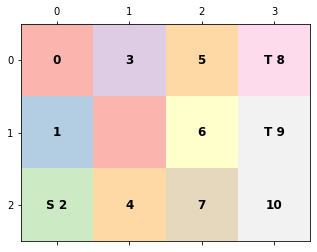

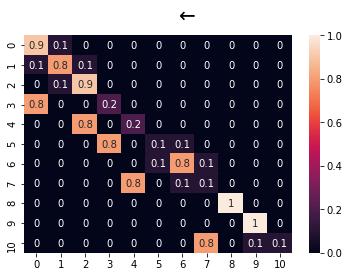

In [7]:
P = enviroment.generate_transition_matrix()
enviroment.plot_board()

plt.suptitle("←", fontsize=20)
ax=sn.heatmap(P[2], annot=True)
plt.show()

Iznad je prikazana tabla po kojoj se agent kreće i svako dozvoljeno polje predstavlja stanje koje ima određenu vrednost. Početno stanje je označeno slovom S, a krajnja stanja slovom T. Ispod se nalazi matrica prelaza koja defiše verovatnoće prelaska u naredno stanje za akciju kretanja levo. Dakle, definisano je preslikavanje pozicije u svako od stanja i za svako stanje je poznata verovatnoća prelaska u naredno u zavisnosti od akcije. 

# 3. Rešavanje poznatog MPO

Ispod se data implementacija klase koja metodom iteracije Q-vrednosti određuje optimalne akcije. 

In [8]:
class MarkovModel:
    
    def __init__(self, rewards, transition_matrix, gamma, tol):
        
        self.rewards = rewards
        self.transition_matrix = transition_matrix
        self.gamma = gamma
        self.tol = tol
        
    def train(self):
        
        num_of_states = self.transition_matrix.shape[1]
        num_of_actions = self.transition_matrix.shape[0]
        
        Q = np.zeros((num_of_states, num_of_actions))
        Q_next = np.zeros_like(Q)
        
        optimal_actions = []
        values = []
        
        count = 0
        
        while True:
            
            count += 1
            
            for state in range(num_of_states):
                for action in range(num_of_actions):
                    
                    # In terminal state rewards stay the same.
                    if self.transition_matrix[action][state][state] == 1:
                        Q_next[state][action] = self.rewards[state]
                        continue
                    
                    step = np.dot(self.transition_matrix[action, state, :], np.amax(Q, axis=1))
                    
                    Q_next[state][action] = self.rewards[state] + self.gamma * step
                
            if (abs(Q_next - Q) < self.tol).all():
                break
                
            Q = Q_next.copy()

            V = np.amax(Q, axis=1)
            P = np.argmax(Q, axis=1)
            
            optimal_actions.append(P)
            values.append(V)
            
        return optimal_actions, values
        

In [9]:
P = enviroment.generate_transition_matrix()
rewards = enviroment.generate_rewards()

## 3.1. Rezultati $\gamma=1$

In [10]:
model = MarkovModel(rewards=rewards, transition_matrix=P, gamma=1, tol=1e-3)

actions_, values_ = model.train()

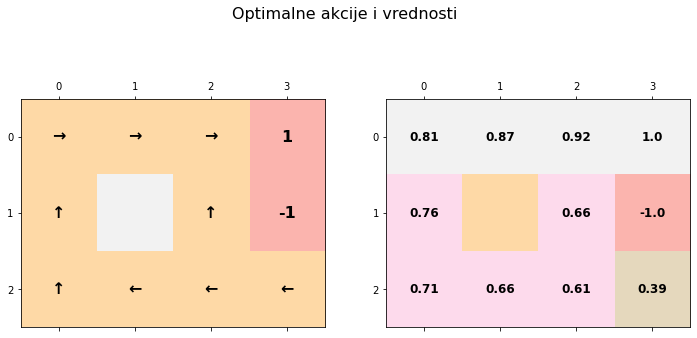

In [11]:
enviroment.plot_actions_values(actions_[-1], values_[-1], "Optimalne akcije i vrednosti")

In [12]:
print(len(actions_))

20


Vidimo da je modelu bilo potrebno 20 iteracija da dođe do rešenja. Interesantna pozicija je ona koja se nalazi između zida i polja sa najvećom kaznom (slično i za poziciju u donjem desnom uglu). Iako postoji šansa da agent sklizne udesno kada krene gore i dobije veliku kaznu, optimalna akcija je ipak ići gore. Razlog za ovo je što je verovatnoća rotacije mala, a model dobija kaznu kada ostaje u istoj poziciji, pa se više isplati da rizikuje i ide gore. 

Dalje prikazujemo kako se akcije i vrednosti menjaju kroz iteracije. Prikazujemo one iteracije u kojima dolazi do prve promene bar jedne akcije. Jedna iteracija podrazumeva promenu svih vrednosti u matrici Q vrednosti. 

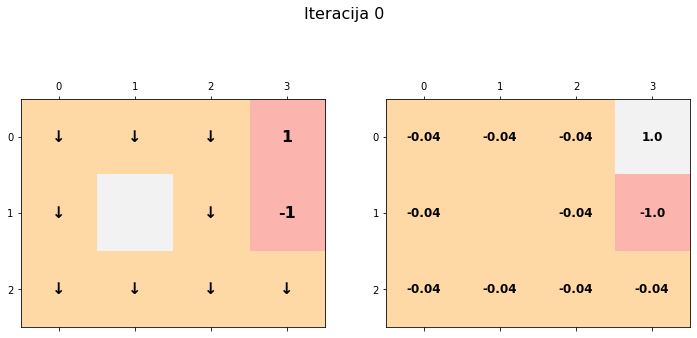

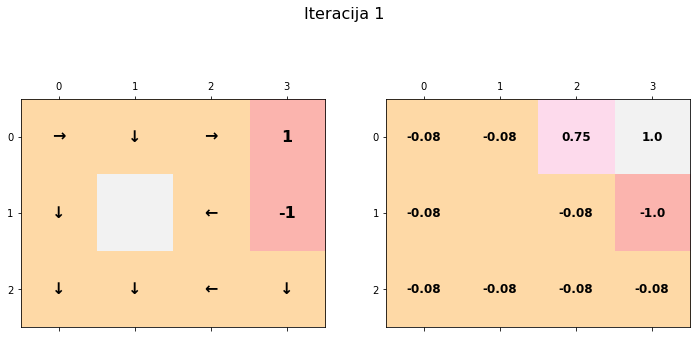

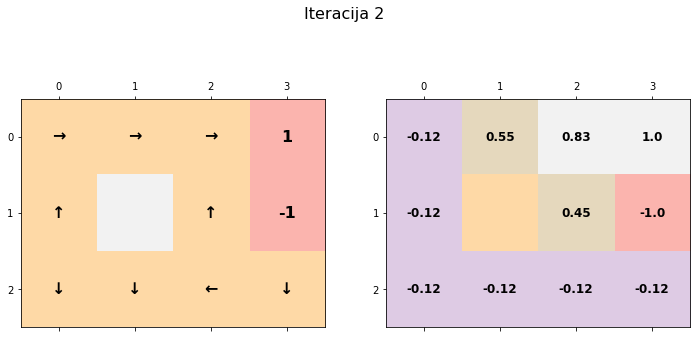

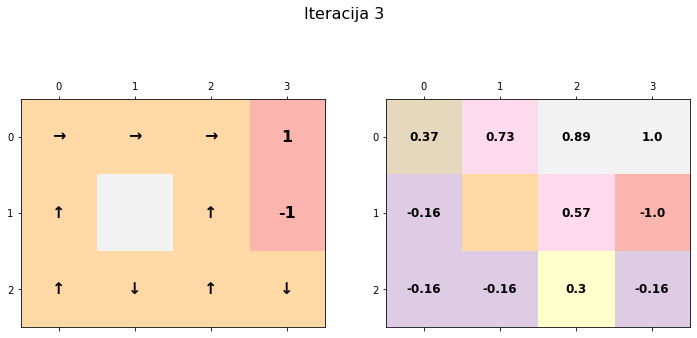

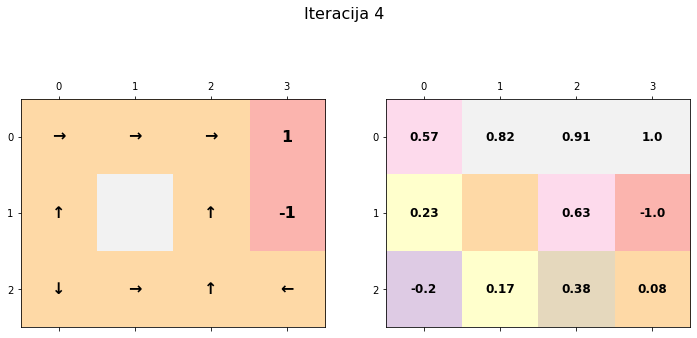

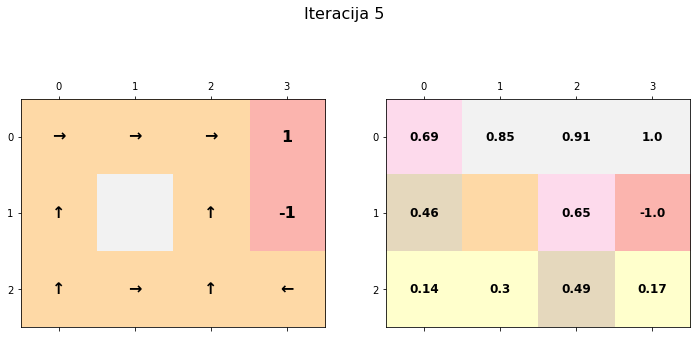

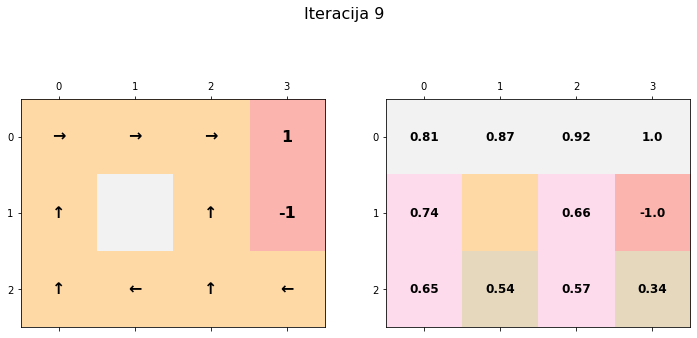

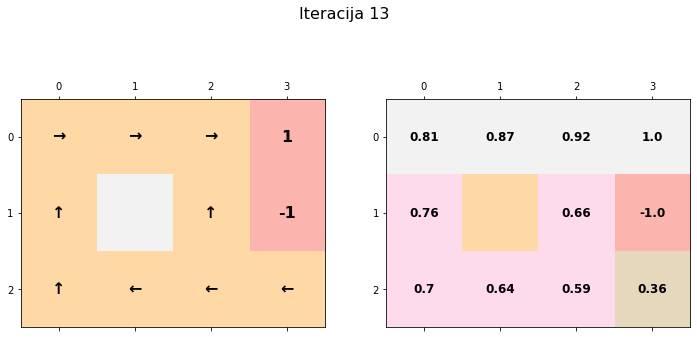

In [13]:
for (i, actions) in enumerate(actions_):
    if i == 0:
        enviroment.plot_actions_values(actions, values_[i], "Iteracija " + str(i))
        continue
    if (actions_[i - 1] != actions).any():
        enviroment.plot_actions_values(actions, values_[i], "Iteracija " + str(i))

Dobijeni rezultati su očekivani za dati algoritam. Nagrade na pozicijama koje su finalne utiču na nagrade na pozicijama koje su pored. Ta promena u narednoj iteraciji povlači promene na pozicijama koje su pored njih i tako dalje. Prema tome, algoritam kreće od konačnih pozicija i ide unazad pokušavajući da da odredi šta bi trebalo da se uradi u zavisnosti od toga koliko je poteza na raspolaganju.

## 3.2. Rezultati $\gamma=0.9$

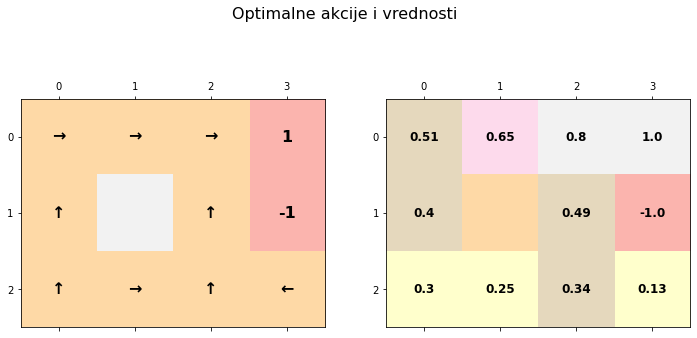

In [14]:
model = MarkovModel(rewards=rewards, transition_matrix=P, gamma=0.9, tol=1e-3)

actions_, values_ = model.train()

enviroment.plot_actions_values(actions_[-1], values_[-1], "Optimalne akcije i vrednosti")

In [15]:
print(len(actions_))

14


Vidimo da smanjivanjem vrednosti parametra $\gamma$ algoritam dolazi do rešenja sa 15 iteracija. Dakle, broj potrebnih iteracija se smanjio. Q-vrednost je određena nagradom u datom stanju i matematičkim očekivanjem najboljih nagrada za naredna stanja, gde je ovo očekivanje pomnoženo parametrom $\gamma$. Vrednost 1 ovog parametra odgovara situaciji u kojoj trenutno stanje procenjujemo i na osnovu njegove nagrade i očekivane nagrade za određenu politiku. Kada se ovaj parametar smanji, manju težinu dajemo onome što će se desiti u narednom potezu. 

Ovo se jasno vidi u razlikama dobijenih vrednosti - iako su akcije iste, vrednosti za svako stanje su manje kada je $\gamma$ manje jer signal matematičkog očekivanja slabi dok propagira kroz naredna polja. Ovo slabljenje ujedno i dovodi do toga da algoritam konvergira sa manje iteracija.

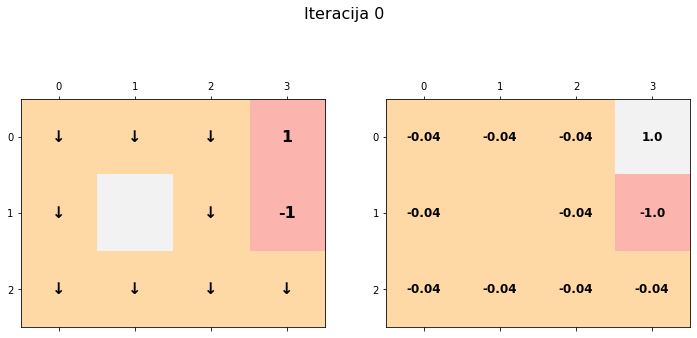

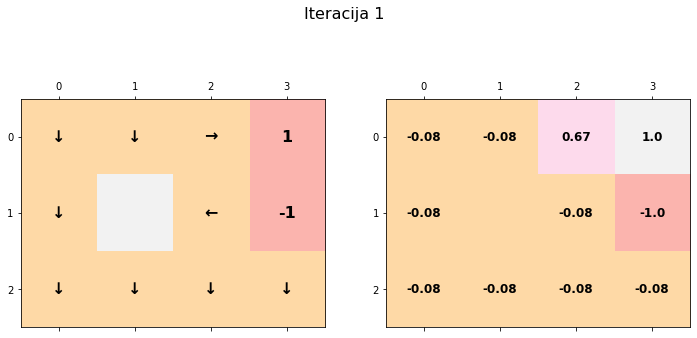

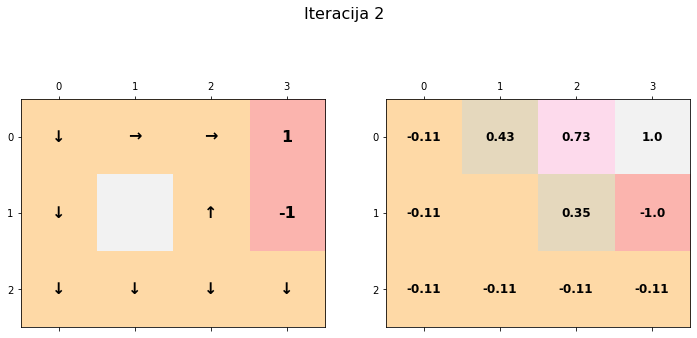

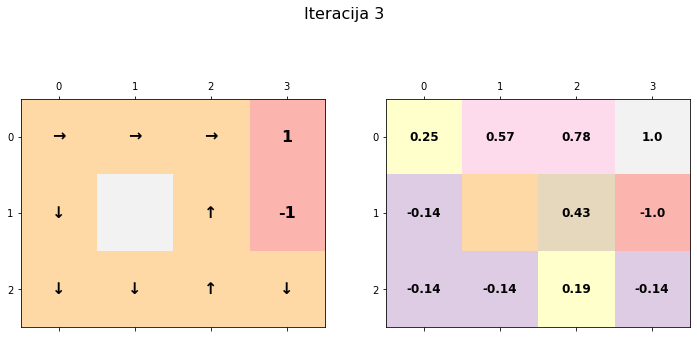

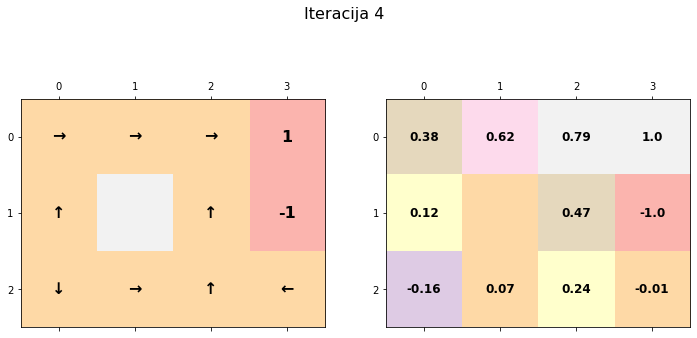

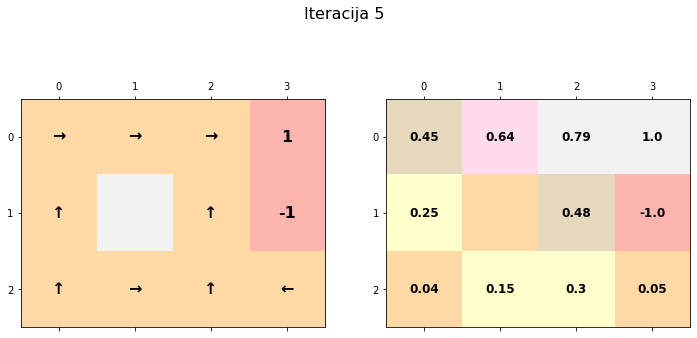

In [16]:
for (i, actions) in enumerate(actions_):
    if i == 0:
        enviroment.plot_actions_values(actions, values_[i], "Iteracija " + str(i))
        continue
    if (actions_[i - 1] != actions).any():
        enviroment.plot_actions_values(actions, values_[i], "Iteracija " + str(i))

Osim što je za manje $\gamma$ manji ukupan broj iteracija, manji je i broj iteracija sa kojim se dolazi do optimalnih akcija. Vidimo da je već posle 5 iteracija algoritam došao do konačnog rešenja (dok je za $\gamma=1$ bilo potrebno 13), a u narednim iteracijama menjao vrednosti, ali to nije uticalo na izbor politike.

## 3.3. Drugačije verovatnoće proklizavanja

U ovom odeljku posmatramo šta se dešava kada su verovatnoće rotacija 0.3, a verovatnoća da agent ide pravo 0.4.

In [17]:
enviroment = BoardEnviromentModel(actions=[(1, 0) , (-1, 0), (0, -1), (0, 1)],
                                  action_symbols = ["↓", "↑", "←", "→"],
                                  rotation_probabilities=[(0, 0.4), (90, 0.3), (-90, 0.3)], 
                                  shape=(3,4), 
                                  terminal_positions=[(0, 3), (1, 3)],
                                  start_position = (2, 0),
                                  walls=[(1,1)], 
                                  default_reward=-0.04, 
                                  rewards=[((0,3), 1), ((1, 3), -1)])

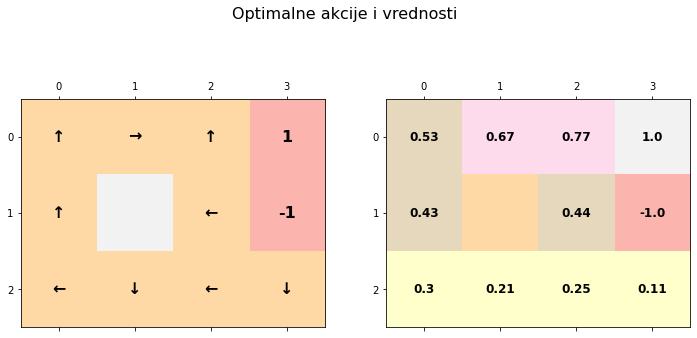

In [18]:
P = enviroment.generate_transition_matrix()
rewards = enviroment.generate_rewards()

model = MarkovModel(rewards=rewards, transition_matrix=P, gamma=1, tol=1e-3)

actions, values = model.train()

enviroment.plot_actions_values(actions[-1], values[-1], "Optimalne akcije i vrednosti")

In [19]:
print(len(actions))

53


Vidimo da se sada politika promenila i ovo je prilično očekivano. Ovo se jasno vidi u "rizičnim" ćelijama. Na primer, u ćeliji koja je između zida i kazne jer sada optimalna politika ići pravo. Pošto je verovatnoća proklizavanja 0.3 u ovoj situaciji se stvarno više isplati ići pravo i udarati u zid dok se ne desi da agent rotira levo ili desno. U startnoj poziciji je takođe izabrana konzervativna akcija koja podrazumeva udaranje u zid dok se ne ode gore, umesto da ide gore i slučajno završi u levoj poziciji. 

Vidimo i da je broj iteracija sada povećan. Intuitivno objašnjenje je to što je sada samo okruženje malo komplikovanije, odnosno, postoji veća nesigurnost u svakoj akciji, pa postaje manje očigledno šta je ispravna odluka.

# 4. Rešavanje nepoznatog MPO

Ispod je data implementacija klase koja implementira Q-učenje. 

In [22]:
class QLearning:
    
    def __init__(self, enviroment, gamma, alpha, epsilon_init, epsilon_end, N,
                 tol, learning_rate, convergence_count, max_iter=10000):
        """
        Creates a Q learning model for given enviroment. 
        
        Parameters
        ----------
        enviroment : enviroment object 
            represents enviroment with which an agent can iteract. 
        gamma: float
            weight of reward for future outcomes
        alpha : float, range (0,1)
            parameter for recursive probability estimation
        epsilon_init : float, range (0, 1)
            initial probability with which current optimal move is selected
        epsilon_end: float, range(0, 1)
            initial probability with which current optimal move is selected. Set to epsilon_init to
            use const epsilon. Epsilon changes as (epsilon_init - epsilon_end)*r + epsilon_end
            r is defined  as max((N-steps))/N, 0)
        N : int
            rate of decay for epsilon 
        tol : float 
            tolerance for convergence detection
        learning_rate : string {"const" "log"}
            when const uses given alpha, when log uses alpha = log(1+t)/(1+t) where t
            is the iteration
        convergence_count : int
            how many times should algorithm "converge" in a row before it's done
        max_iter : stop after max_iter number of episodes
        
        """
        self.enviroment = enviroment
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon_init = epsilon_init
        self.epsilon_end = epsilon_end
        self.N = N
        self.tol = tol
        self.learning_rate = learning_rate
        self.convergence_count = convergence_count
        self.max_iter = max_iter
        
        
    def _get_action(self, state):
        
        a_list = ["optimal", "random"]
        distribution = [1 - self.epsilon, self.epsilon]
        choice = random.choices(a_list, distribution)
        
        if choice == "optimal":
            return np.argmax(self.Q[state, :])
        else:
            return np.random.randint(low=0, high=self.num_of_actions)
        
        
    def train(self):
        
        self.num_of_states = len(self.enviroment.states_map)
        self.num_of_actions = len(self.enviroment.actions)
        
        self.Q = np.zeros((self.num_of_states, self.num_of_actions))
        self.Q_next = np.zeros_like(self.Q)
        
        optimal_actions = []
        values = []
        
        rewards = self.enviroment.generate_rewards()
        count = 1
        
        Q = self.Q
        Q_next = self.Q_next
        
        # Mark terminal states with their reward.
        for state in self.enviroment.terminal_states:
            for action in range(self.num_of_actions):
                self.Q_next[state][action] = rewards[state]
                
        break_count = 0
        
        
        while True:
            
            # Prepare learning rate.
            if self.learning_rate == "log":
                self.alpha = math.log(count + 1) / (count + 1)
                
            # Prepare epsilon.
            r = max((self.N -count) / self.N, 0)
            self.epsilon = (self.epsilon_init - self.epsilon_end)*r + self.epsilon_end
            
            # Episode starts with start state and it's done when it reaches terminal state.
            state = self.enviroment.start_state
            
            while state not in self.enviroment.terminal_states:
                
                action = self._get_action(state)
                next_state = self.enviroment.interact(state, action)
                
                q = rewards[state] + self.gamma * np.amax(self.Q[next_state, :])
                
                self.Q_next[state, action] = self.Q[state, action] + self.alpha * (q - self.Q[state, action])
                
                state = next_state
                          
                    
            if count >= self.max_iter:
                break
                
            if (abs(self.Q_next - self.Q) < self.tol).all():
                break_count += 1
                if break_count >= self.convergence_count:
                    break
            else:
                break_count = 0
                
            self.Q = self.Q_next.copy()
            
            V = np.amax(self.Q, axis=1)
            P = np.argmax(self.Q, axis=1)
            
            optimal_actions.append(P)
            values.append(V)
            
            count += 1
            
        return optimal_actions, values

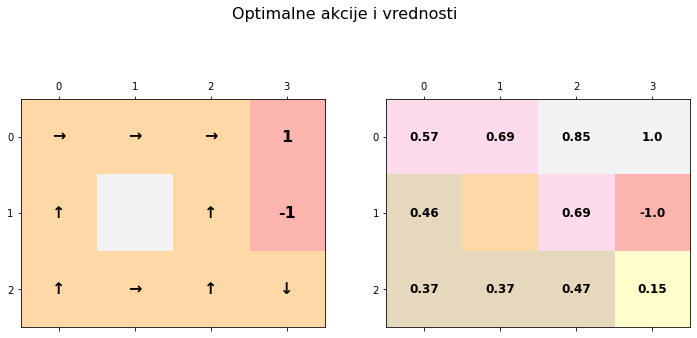

In [28]:
enviroment = BoardEnviromentModel(actions=[(1, 0) , (-1, 0), (0, -1), (0, 1)],
                                  action_symbols = ["↓", "↑", "←", "→"],
                                  rotation_probabilities=[(0, 0.8), (90, 0.1), (-90, 0.1)], 
                                  shape=(3,4), 
                                  terminal_positions=[(0, 3), (1, 3)], 
                                  start_position = (2, 0),
                                  walls=[(1,1)], 
                                  default_reward=-0.04, 
                                  rewards=[((0,3), 1), ((1, 3), -1)])

model = QLearning(enviroment=enviroment, 
                  gamma=0.9, 
                  alpha=0.1, 
                  epsilon_init=0.6, 
                  epsilon_end = 0.6,
                  N = 10,
                  tol=10e-3, 
                  learning_rate="const",
                  convergence_count=2)

actions, values = model.train()

enviroment.plot_actions_values(actions[-1], values[-1], "Optimalne akcije i vrednosti")

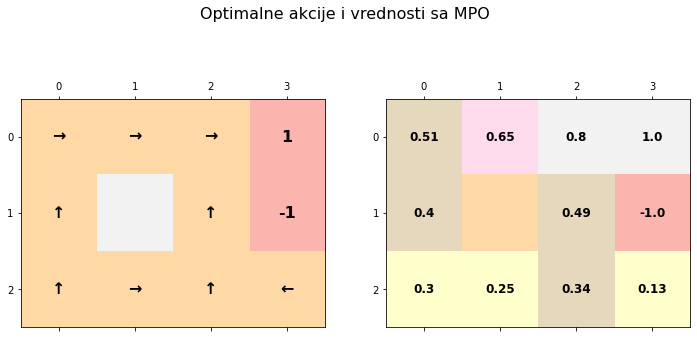

In [29]:
enviroment.plot_actions_values(actions_[-1], values_[-1], "Optimalne akcije i vrednosti sa MPO")

Vidimo da vrednosti parametara konstantno $\epsilon=0.6$, konstaantno $\alpha=0.1$ i zadatog broja zaredom ispunjenih uslova konvergencije 2 dobijamo jako slične vrednosti kao i u slučaju kada su verovatnoće prelaza u naredno stanje poznate. Politika je u oba slučaja identična.

Parametar $\alpha$ je izabran na osnovu toga što je poznato da pri rekurzivnom određivanju verovatnoće parametar uglavnom treba da bude oko 0.05, odnosno 0.1. 

In [30]:
print(len(actions))

500


Broj iteracija, odnosno epizoda, koje su sada potrebne je mnogo veći, ali treba da se uzme u obzir da je agent ujedno i istraživao svoje okruženje. 

## 4.1. Ponašanje algoritma u zavisnosti od $\epsilon$ parametra

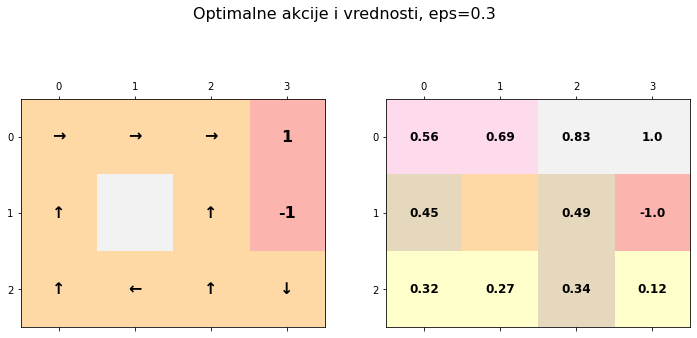

In [31]:
model = QLearning(enviroment=enviroment, 
                  gamma=0.9, 
                  alpha=0.1, 
                  epsilon_init=0.3, 
                  epsilon_end = 0.3,
                  N = 10,
                  tol=10e-3, 
                  learning_rate="const",
                  convergence_count=4)

actions, values = model.train()

enviroment.plot_actions_values(actions[-1], values[-1], "Optimalne akcije i vrednosti, eps=0.3")

In [32]:
print(len(actions))

9999


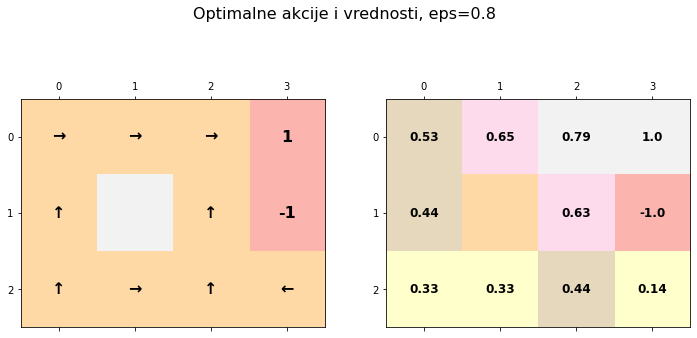

In [33]:
model = QLearning(enviroment=enviroment, 
                  gamma=0.9, 
                  alpha=0.1, 
                  epsilon_init=0.3, 
                  epsilon_end = 0.3,
                  N = 10,
                  tol=10e-3, 
                  learning_rate="const",
                  convergence_count=4)

actions, values = model.train()

enviroment.plot_actions_values(actions[-1], values[-1], "Optimalne akcije i vrednosti, eps=0.8")

In [34]:
print(len(actions))

454


Vidimo da ovaj parametar može da utiče i na izbor politike kao i na broj iteracija koji je potreban da se dođe do rešenja. 

Sa verovatnoćom $\epsilon$ biramo akciju slučajno, u suprotnom biramo onu koja je na osnovu do sada stečenog iskustva optimalna. Prema tome, ovaj parametar nam govori koliko agent rizikuje dok uči, a koliko se oslanja na ono što je već naučeno. Kada je $\epsilon$ manje, agent se više oslanja na prethodno stečena iskustva. Ovo ga doduše ujedno i stavlja u situaciju u kojoj je manje verovatno da nauči nešto novo. 

Za veliku vrednost ovog parametra agent stiče više iskustva jer nasumično bira akcije mnogo češće nego što se oslanja na trenutno naučeno. U zavisnosti od toga kako se odigraju epizode agent može da izabere i konzervativnu strategiju. U ovoj situaciji uglavnom imamo i manje iteracija jer se brže nauči okruženje.

Broj iteracija za malo $\epsilon$ je prilično nepredvidiv. Nekada je potrebno jako malo iteracija, a nekad jako mnogo. Ovo nije čudno. Sa jedne strane, mala vrednost znači da se držimo naučenog, što može da znači da nema mnogo mesta za promene, pa algoritam staje jer ne dolazi do promene u matrici Q-vrednosti. Sa druge strane, mala vrednost ujedno znači da jako sporo istražujemo okruženje, pa je sa tim i za očekivati veliki broj iteracija. Otud je broj iteracija često ili veoma veliki ili veoma mali.

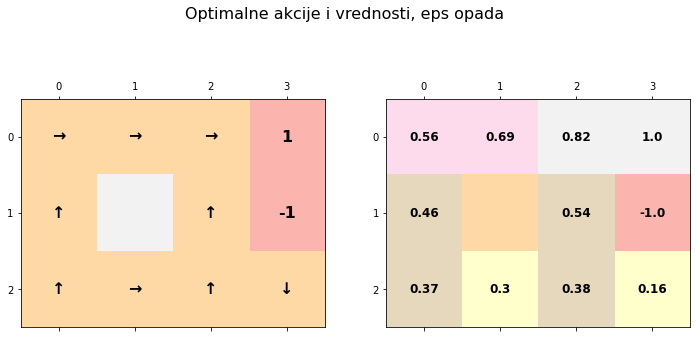

In [38]:
model = QLearning(enviroment=enviroment, 
                  gamma=0.9, 
                  alpha=0.1, 
                  epsilon_init=0.9, 
                  epsilon_end = 0.2,
                  N = 10,
                  tol=10e-3, 
                  learning_rate="const",
                  convergence_count=2)

actions, values = model.train()

enviroment.plot_actions_values(actions[-1], values[-1], "Optimalne akcije i vrednosti, eps opada")

In [39]:
print(len(actions))

317


Ovde smo sa jako malo iteracija uspeli da dođemo do politike i vrednosti koje su jako slične onima koje dobijemo kada koristimo Markovljev proces odlučivanja. Razlog za manji broj iteracija je u tome što se $\epsilon$ smanji i tada algoritam ne može mnogo da se poboljša jer prosto ne prikuplja toliko novih informacija. Jasno je da parametar $N$ koji određuje kojom se brzinom verovatnoća biranja slučajne akcije smanjuje mnogo utiče na to kako se ponaša naš algoritam i njegove najbolje vrednosti su pre svega definisane time kakvo je okruženje. 

## 4.2. Ponašanje algoritma u zavisnosti od stope učenja

U ovom odeljku razmatramo šta se dešava kada je parametar učenja konstantan i kada se menja logaritamski.

In [40]:
def plot_values_thorugh_episodes(values_left, values_right, ref_values, title_left, title_right):

    episodes_left = np.arange(len(values_left))
    episodes_right = np.arange(len(values_right))
    ref_values = np.array(ref_values)
    values_left = np.array(values_left)
    values_right = np.array(values_right)
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,10))
    
    axes[0].title.set_text = title_left
    axes[1].title.set_text = title_right
    
    for i in range(0, 5):
        axes[0].plot(episodes_left, values_left[:, [i]], label="stanje " + str(i))
        axes[0].scatter(episodes_left[-1], ref_values[-1][i], lw=2, edgecolors='k')
        
    for i in range(0, 5):
        axes[1].plot(episodes_right, values_right[:, [i]], label="stanje " + str(i))
        axes[1].scatter(episodes_right[-1], ref_values[-1][i], lw=2, edgecolors='k')
        
    axes[0].legend(loc="best")
    axes[1].legend(loc="best")
    
        
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,10))
    
    axes[0].title.set_text = title_left
    axes[1].title.set_text = title_right
    
    for i in range(5, 11):
        if i == 8 or i == 9:
            continue
        axes[0].plot(episodes_left, values_left[:, i], label="stanje " + str(i))
        axes[0].scatter(episodes_left[-1], ref_values[-1][i], lw=2, edgecolors='k')
        
    for i in range(5, 11):
        if i == 8 or i == 9:
            continue
        axes[1].plot(episodes_right, values_right[:, i], label="stanje " + str(i))
        axes[1].scatter(episodes_right[-1], ref_values[-1][i], lw=2, edgecolors='k')
        
    axes[0].legend(loc="best")
    axes[1].legend(loc="best")

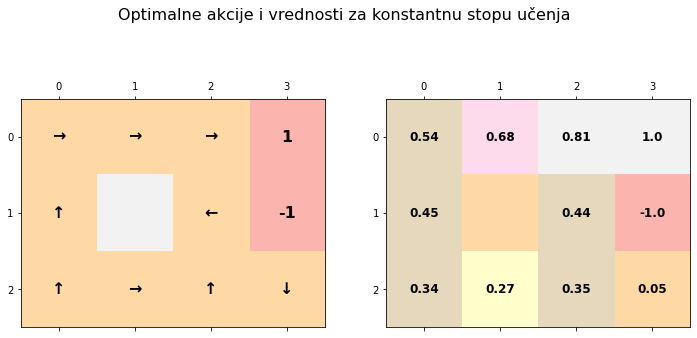

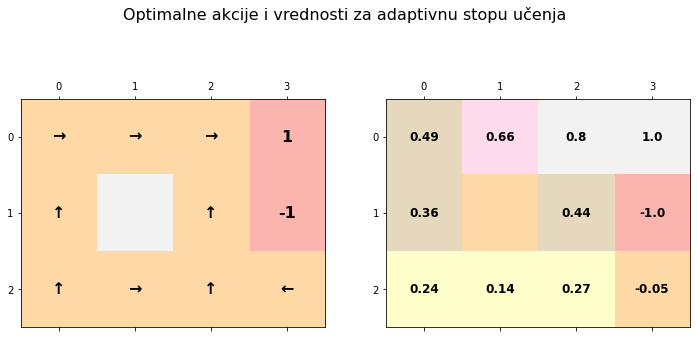

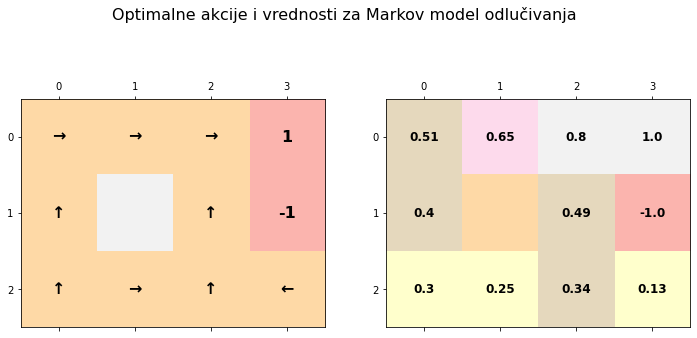

In [42]:
model = QLearning(enviroment=enviroment, 
                  gamma=0.9, 
                  alpha=0.05, 
                  epsilon_init=0.9, 
                  epsilon_end = 0.2,
                  N = 10,
                  tol=10e-4, 
                  learning_rate="const",
                  convergence_count=1)

actions_const, values_const = model.train()

model = QLearning(enviroment=enviroment, 
                  gamma=0.9, 
                  alpha=0.1, 
                  epsilon_init=0.9, 
                  epsilon_end = 0.2,
                  N = 10, 
                  tol=10e-4, 
                  learning_rate="log",
                  convergence_count=1)

actions_log, values_log = model.train()

model = MarkovModel(rewards=enviroment.generate_rewards(), 
                    transition_matrix=enviroment.generate_transition_matrix(), 
                    gamma=0.9, 
                    tol=1e-4)

actions_ref, values_ref = model.train()


enviroment.plot_actions_values(actions_const[-1], values_const[-1], "Optimalne akcije i vrednosti za konstantnu stopu učenja")
enviroment.plot_actions_values(actions_log[-1], values_log[-1], "Optimalne akcije i vrednosti za adaptivnu stopu učenja")
enviroment.plot_actions_values(actions_ref[-1], values_ref[-1], "Optimalne akcije i vrednosti za Markov model odlučivanja")

Izabrano je da se verovatnoća biranja slučajne akcije vremenom smanjuje. Dobijena politika je u sva tri slučaja skoro ista (nekada i potpuno ista). Vrednosti su takođe dosta slične. Možemo da vidimo da je politika u poljima u trećoj koloni jako osetljiva na relativno male promene vrednosti. 

Adaptivna stopa učenja vrlo brzo dovodi do male vrednosti parametra učenja, pa je potrebno povećati toleranciju algoritma da se on ne bi prerano završio. Da bi poređenje bilo fer ista tolerancija je zadata algoritmu koji koristi konstantnu stopu učenja. Ovo je dovelo do toga da se mora izabrati da algoritam odmah stane čim detektuje da nije došlo do značajne promene u Q matrici jer u suprotnom obučavanje traje predugo (razlog će biti jasan sa grafika promena vrednosti kroz epizode).

In [43]:
print("Broj iteracija za konstantnu stopu učenja ", len(actions_const))
print("Broj iteracija za adaptivnu stopu učenja ", len(actions_log))
print("Broj iteracija za Markovljev proces odlučivanja ", len(actions_ref))

Broj iteracija za konstantnu stopu učenja  9999
Broj iteracija za adaptivnu stopu učenja  411
Broj iteracija za Markovljev proces odlučivanja  16


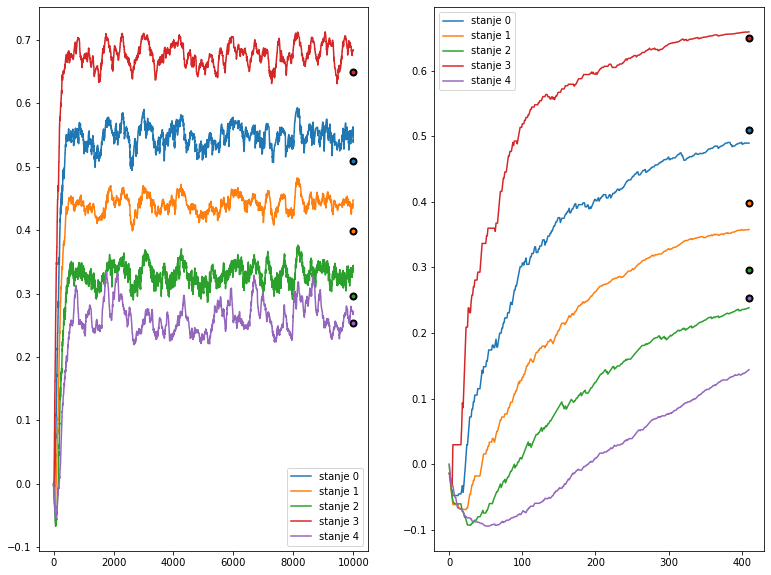

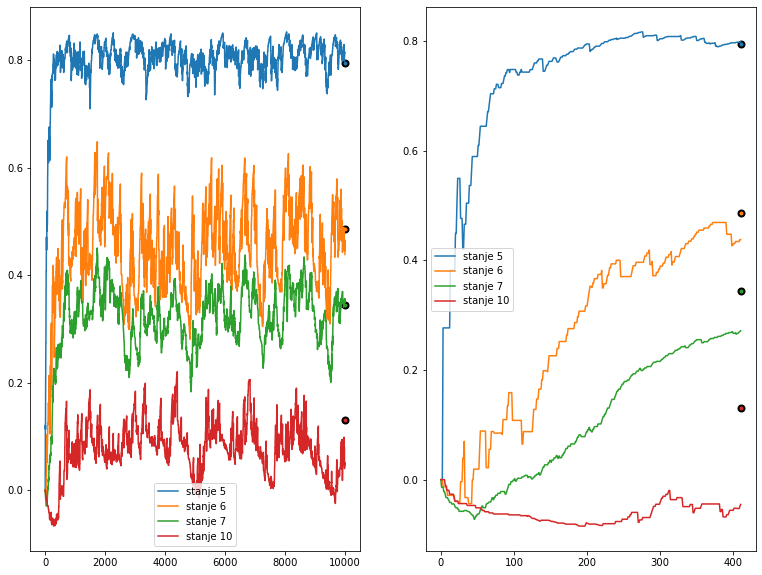

In [44]:
plot_values_thorugh_episodes(values_left=values_const,
                             values_right=values_log, 
                             ref_values=values_ref, 
                             title_left="Konstantna stopa učenja", 
                             title_right="Adaptivna stopa učenja")

Na slici iznad su prikazane promene vrednosti kroz epizode za konstantnu i adaptivnu stopu učenja. Rezultati dobijeni korišćenjem matrice prelaza su korišćeni kao referentne tačke i obeležene su na grafiku. Ovo su ujedno i tačke u kojima bi naš algoritam trebalo da završi. 

Iako bismo na osnovu vrednosti koje smo dobili na kraju i politike koja je ista mogli da tvrdimo da razlika između ovih algoritama i nije velika, kada pogledamo grafike promene vrednosti kroz iteracije postaje jasno da su dobri rezultati sa konstantnom stopom učenja često posledica sreće. Jasno je i zašto nam je potreban tako veliki broj iteracija da bi se algoritam zaustavio. Jako je očigledno da je stopa učenja na početku dobra, ali da vrlo brzo postaje prevelika. Kada minimizujemo funkciju korak koji se pravi je prevelik i konstantno oscilujemo oko optimalnih vrednosti.

Kada koristimo adaptivnu stopu učenja konvergencija ka optimalnim tačkama je dosta sigurnija, ali ako se vrednosti nisu dovoljno povećale na početku, kada se u narednim iteracijama smanjuje vrednost parametra učenja, vrednosti stanja koja su u zaostatku imaju problem da stignu do optimalnih vrednosti jer jako sporo rastu. Ovo je glavni problem sa adaptivnom stopom učenja. Ako smo na početku pogrešili dalje ispravljanje postaje jako teško. Ovo je posebno očigledno u stanju koje je u donjem desnom uglu jer se i u to stanje relativno retko ulazi.

Problemi koji postoje sa konstantnom stopom učenja mogu da se prevaziđu. Vidimo da se optimalne vrednosti kriju u srednjoj vrednosti, pa bismo to mogli da iskoristimo. Dakle, uz neko usrednjavanje signala možemo dobijemo rešenja koja su jako bliska optimalnim. Ipak, broj iteracija bi svakako bila mana u odnosu na adaptivnu stopu učenja.

Mane adaptivne stope učenja mogu da se prevaziđu modifikovanjem funkcije stope učenja. Na primer, čak i množenje stope učenja nekom konstantom može da prevaziđe ovaj problem ako se ona izabere na odgovarajući način - tako da podigne vrednosti u najranijim iteracijama dovoljno visoko (ali ne previše), tako da nijedna ne zaostaje. Ona će takođe da zavisi i od parametra $\epsilon$ pa se i na taj način mogu poboljšati rezultati. Takođe je jasno da je vrednost stanja najpribližnija optimalnoj za ona stanja koja se nalaze na početku epizode jer se ona i najčešće ponavljaju. 

Dodatno poboljšanje adaptivne stope učenja bi moglo da broji koliko se puta agent našao u nekom stanju i na osnovu toga bi se parametar učenja menjao, a ne na osnovu broja epizoda. Na ovaj način stanja u koja se ne ulazi često ne bi bila u zaostatku. Ipak nije potpuno fer koristiti istu stopu učenja i za ona stanja kroz koja se prolazi u skoro svakoj epizodi i za ona koja nisu tako česta. 


# 5. Zaključak

Izložena rešenja su sa programerske tačke gledišta pravljena tako da budu što jednostavnija i lakša za izmenu i praćenje. Ovim je svakako izgubljeno na brzini izvršavanja na mnogim mestima, ali to nije toliki problem jer se ipak radi o obučavanju modela, a ne o programu koji treba da se izvršava u realnom vremenu.

Prikazana su dva slučaja učenja sa podsticanjem - Markovljev proces odlučivanja i Q-učenje. Makrovljev proces odlučivanja je intuitivan i daje jako dobre rezultate. Nažalost, zahteva poznavanje matrice prelaza koja uglavnom nije poznata. 

Q-učenje je učenje u pravom smislu te reči jer agent zaista istražuje svoje okruženje i kroz interakciju sa njim uči i poboljšava svoju politiku. Videli smo da su rezultati jako dobri kada se koristi adaptivna stopa učenja. Sa druge strane, ovaj pristup se zasniva na slučajnosti, pa se može dobiti i drugačija politika za iste parametre. 